In [1]:
#import all the usefull packages
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt
import os
import numpy as np
import mapclassify
import contextily as ctx
import osmnx as ox
from geopandas.tools import geocode
import networkx as nx
from shapely.geometry import Point, LineString, Polygon
from geopandas.tools import geocode
import folium
import requests
import geojson



part 1: reading and fetching all needed data

In [2]:
#using osmnx to fetch the driving network in helsinki area
place_name = "Helsinki, Finland"
graph = ox.graph_from_place(place_name, network_type='drive')

# Project the data
graph_proj = ox.project_graph(graph)
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

# checking crs of project data
CRS(edges_proj.crs).to_epsg()

32635

In [3]:
# using osmnx to fetch the coordinate point of my address
geocoded_place = ox.geocode_to_gdf('Juustenintie 3, Helsinki')

# Re-project into the same CRS as the road network
geocoded_place = geocoded_place.to_crs(CRS(edges_proj.crs))

# Get centroid as shapely point
origin = geocoded_place["geometry"].centroid.values[0]

#checking crs
CRS(edges_proj.crs).to_epsg()
print(origin)

POINT (381976.0900362718 6680608.616168542)


In [4]:
#reading health stations data
data = pd.read_csv("health_centers.txt", sep=';')

# Geocode the addresses using Nominatim
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_xx', timeout=4)

# changed crs to 32635 the same crs of project data
geo = geo.to_crs(epsg=32635)

# Get origin (my address) x and y coordinates
orig_xy = (origin.y, origin.x)

# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
orig_node_id = ox.get_nearest_node(graph_proj, orig_xy, method='euclidean')

# Get target x and y coordinates
target_xy = []
for i in geo['geometry']:
    target_xy.append((i.y, i.x))
# Find the node in the graph that is closest to the target point (here, we want to get the node id)

target_node_id  = []
for i in target_xy:
    target_node_id .append(ox.get_nearest_node(graph_proj, i , method='euclidean'))
routes1 = []
for j in target_node_id:
        routes1.append( nx.shortest_path(graph_proj,orig_node_id, j, weight="length"))

# find shortest path
shortest_paths = []
for i in routes1:
    shortest_paths.append(nodes_proj.loc[i])

#remove the path that value is 0    
shortest_paths = [i for i in shortest_paths if len(i) >1] 

#convert shortest part into a linestring
route_line = []
for i in shortest_paths:
    route_line.append(LineString(list(i.geometry.values)))

# create the dataframe routes that contian all the shortest paths from my place to all health centers
routes = []     
for i in route_line:
    routes.append(gpd.GeoDataFrame([[i]], geometry='geometry', crs=edges_proj.crs, columns=['geometry']))
    
#concat all dataframe into one
routes = pd.concat(routes)

# Calculate the route length
routes['route_dist'] = routes.length

#assign the shortest parth lenght from my place to each health center to datatframe that have cooritrate of each healthcare center
lengths = []
for i in routes['route_dist']:
    lengths.append(i)    
geo['distance'] = lengths
geo.head()

,geometry,address,distance
0,POINT (383904.190 6677992.318),"5, Huovitie, Pohjois-Haaga, Haaga, Läntinen su...",5666.685834
1,POINT (393497.712 6681944.200),"Jakomäen terveysasema, 8, Vuorensyrjä, Jakomäk...",16705.373511
2,POINT (388014.405 6674057.640),"Kalasataman terveys- ja hyvinvointikeskus, 14,...",11790.027216
3,POINT (383159.273 6679781.667),"4, Laulukuja, Kannelmäki, Kaarela, Läntinen su...",4877.856627
4,POINT (384499.275 6674679.236),"Rakennus 1, 8, Lääkärinkatu, Laakso, Läntinen ...",9098.870599


In [5]:

# Make a table join and named it geodata between the geocoded addresses (geo) and the original addresses (data) in order to link the numerical coordinates and the id and name of each shopping center.
geodata = geo.join(data)

#changing crs to 3879, finland's system
geodata = geodata.to_crs(epsg=3879)

#add a buffer to data frame to calculate the population in 1,5 km buffer from each healthcare center.
geodata['buffer'] = geodata.buffer(distance = 1500) 

#Replace the values in geometry column with the values of buffer column:
geodata['geometry'] = geodata['buffer']

# drop all the comlumns except id, name, and geometry
geodata.drop(geodata.columns.difference(['id', 'name', 'geometry']), 1, inplace = True)
geodata.head()

,geometry,id,name
0,"POLYGON ((25496195.657 6678824.526, 25496188.4...",0,Haaga Health Station
1,"POLYGON ((25505667.376 6683066.345, 25505660.1...",1,Jakomäki Health Station
2,"POLYGON ((25500424.189 6675015.239, 25500416.9...",2,Kalasatama Health Station
3,"POLYGON ((25495396.680 6680590.897, 25495389.4...",3,Kannelmäki Health Station
4,"POLYGON ((25496890.992 6675530.213, 25496883.7...",4,Kivelä Health Station


In [6]:
# name the url of the website that contain population of helsinki in each area.
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame-pop from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

#rename the column asukkaita to pop18
pop = pop.rename(columns={'asukkaita': 'pop18'})
pop = pop[["pop18", "geometry"]]

#chaning the crs of pop dataframe to the same with geodata dataframe
pop.crs = CRS.from_epsg(3879).to_wkt()
geodata = geodata.to_crs(pop.crs)
pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


In [7]:
# Create a spatial join between grid layer and buffer layer. 
join = gpd.sjoin(pop, geodata, how='inner', op = 'within')

# creating the empty list to append the value of population of each health center
population = []
grouped = join.groupby(by = 'name')
for name, group in grouped:
    popu = sum(group['pop18'])
    population.append(popu)

#assign the population around each helth station to dataframe that have coordirate of each health center.    
geo['pop'] = population

#adding the new column name to geo dataframe
geo['name'] = data['name']
geo 

,geometry,address,distance,pop,name
0,POINT (383904.190 6677992.318),"5, Huovitie, Pohjois-Haaga, Haaga, Läntinen su...",5666.685834,20217,Haaga Health Station
1,POINT (393497.712 6681944.200),"Jakomäen terveysasema, 8, Vuorensyrjä, Jakomäk...",16705.373511,12857,Jakomäki Health Station
2,POINT (388014.405 6674057.640),"Kalasataman terveys- ja hyvinvointikeskus, 14,...",11790.027216,20722,Kalasatama Health Station
3,POINT (383159.273 6679781.667),"4, Laulukuja, Kannelmäki, Kaarela, Läntinen su...",4877.856627,26117,Kannelmäki Health Station
4,POINT (384499.275 6674679.236),"Rakennus 1, 8, Lääkärinkatu, Laakso, Läntinen ...",9098.870599,30897,Kivelä Health Station
5,POINT (392984.429 6679549.506),"Kivikonkaari, Kivikko, Mellunkylä, Itäinen suu...",15315.340778,21483,Kivikko Health Station
6,POINT (393916.557 6679425.154),"Kontulan terveysasema, 3, Ostoskuja, Kontula, ...",17003.185913,28368,Kontula Health Station
7,POINT (392106.644 6672875.538),"2 A, Koulutanhua, Yliskylä, Laajasalo, Kaakkoi...",17098.180627,11507,Laajasalo Health Station
8,POINT (382497.949 6671236.644),"Lauttasaaren terveyskeskus, 6, Taivaanvuohenti...",13413.772653,19159,Lauttasaari Health Station
9,POINT (389381.816 6681373.253),"Malmin terveysasema ja hammashoitola, 4, Talve...",12464.700270,24897,Malmi Health Station


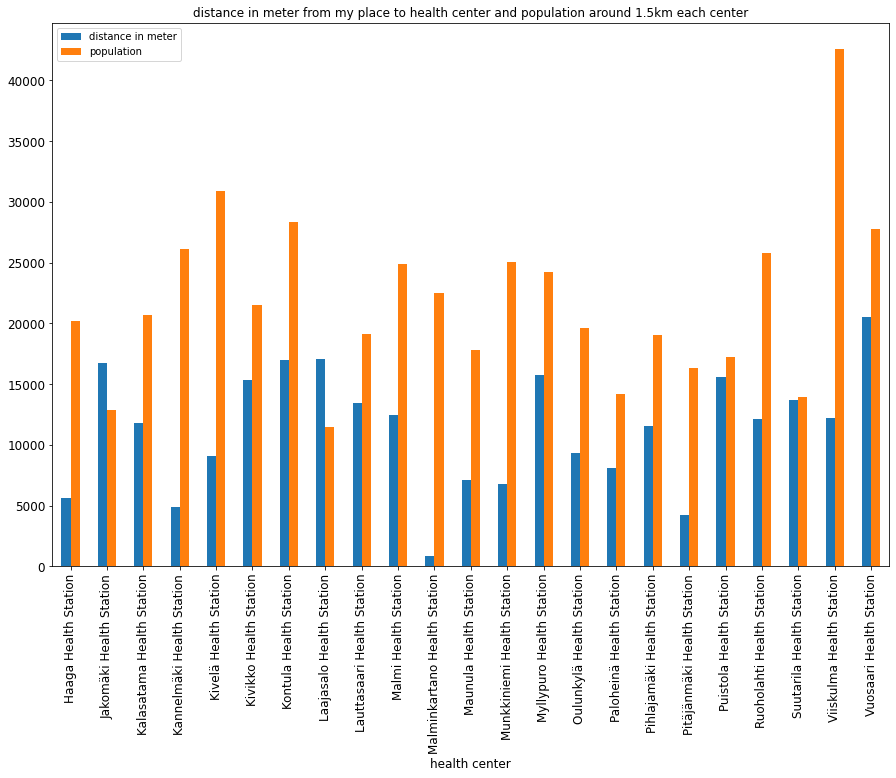

In [8]:
#set index according to the name column so i can plot it at x asix
geo = geo.set_index('name')
ax = geo[['distance','pop']].plot(kind='bar', title ="distance in meter from my place to health center and population around 1.5km each center", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("health center", fontsize=12)
plt.gca().legend(('distance in meter','population'))
plt.savefig('analyze.png')

plt.show()




part 3.2 maping the shortest part fromn my place to each health center

In [9]:
# Create a Geo-id which is needed by the Folium (it needs to have a unique identifier for each row)
geodata['geoid'] = geo.index.astype(str)

#assign population column to geodata dataframe
geodata['pop'] = population

# Select only needed columns
geodata = geodata[['geoid', 'pop', 'geometry']]

# Create a Map instance
m = folium.Map(location=[60.25, 24.8], tiles = "cartodbpositron", zoom_start=11, control_scale=True)

#add marker of my place to the map
folium.Marker(
    location=[origin.y, origin.x],
    popup='Kumpula Campus',
    icon=folium.Icon(color='green', icon='ok-sign'),
).add_to(m)
# Convert points to GeoJSON
points_gjson = folium.features.GeoJson(geo, name="Public health stations in helsinki",)
# Add points to the map instance
points_gjson.add_to(m)

# add  the shortest path from my place to each health station to the map
folium.Choropleth(
    routes[routes.geometry.length>0.001],
    line_weight=3,
    line_color='blue'
).add_to(m)

#add the tooltip to each health station to show the distance from my place to each station as well as the population around it
folium.features.GeoJson(geodata,  
                        name='Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['pop', 'geoid'],
                                                                aliases = ['Population: ', 'health station: '],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)
# Create a layer control object and add it to our map instance
folium.LayerControl().add_to(m)

#save map
outfp = "choropleth_map.html"
m.save(outfp)
#Show map
m

conclusion:
I think i do the good job to fetch my idea to finish the assignment. 
However I would do better if the notebook environment could be stronger to restreive bigger data such as restreivr bigger location.
the servere automatically crack if I try to restreive the data of Uusimaa area.